In [1]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import polars as pl

# Directory containing the testing images
train_dir = 'data/set-A_train'
test_dir = 'data/set-B_test'

# load labels
train_labels_df = pl.read_csv(f'{train_dir}/image_labels.csv')
test_labels_df = pl.read_csv(f'{test_dir}/image_labels.csv')

# Row and col limits (everything outside is irrelevant)
ORIG_IMG_ROW_LIM_1  = 60
ORIG_IMG_ROW_LIM_2  = 430
ORIG_IMG_COL_LIM_1  = 40
ORIG_IMG_COL_LIM_2  = 600


# Load images from test set
train_images = []
train_labels = []
for filename in tqdm(os.listdir(train_dir), desc='Loading images from train data'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(train_dir, filename)
        img = Image.open(img_path)
        img = img.crop((ORIG_IMG_COL_LIM_1, ORIG_IMG_ROW_LIM_1, ORIG_IMG_COL_LIM_2, ORIG_IMG_ROW_LIM_2))  # Crop the image
        img_array = np.array(img)
        train_images.append(img_array)
        train_labels.append(filename)

train_images = np.array(train_images)
print(f'Loaded {len(train_images)} images for training.')

# Load images from test set
test_images = []
test_labels = []
for filename in tqdm(os.listdir(test_dir), desc='Loading images from test data'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path)
        img = img.crop((ORIG_IMG_COL_LIM_1, ORIG_IMG_ROW_LIM_1, ORIG_IMG_COL_LIM_2, ORIG_IMG_ROW_LIM_2))  # Crop the image
        img_array = np.array(img)
        test_images.append(img_array)
        test_labels.append(filename)

test_images = np.array(test_images)
print(f'Loaded {len(test_images)} images for testing.')

Loading images from train data: 100%|██████████| 1636/1636 [00:05<00:00, 274.64it/s]


Loaded 1635 images for training.


Loading images from test data: 100%|██████████| 401/401 [00:01<00:00, 292.05it/s]


Loaded 400 images for testing.


In [3]:
# Filter the dataframe and get the row
row = train_labels_df.filter(pl.col('Filename') == '20171105_185451_Location-4C_Heading-East_Ship-Cruiser-1.jpg')
print(row['Location'].item())

4C


In [13]:
def preprocess_images_ship_present(images, labels, labels_df, target_size=(128, 128)):

    processed_images = []
    is_nonempty_labels = []
    locations = []
    heading = []
    shiptype = []


    for img, label in tqdm(zip(images, labels), desc='Preprocessing images\t', total=len(images)):
        # Resize the image
        img_resized = Image.fromarray(img).resize(target_size)
        img_array = np.array(img_resized)
        
        # Normalize the pixel values
        img_normalized = img_array / 255.0
        
        processed_images.append(img_normalized)
        # Append the corresponding Is_nonempty value
        is_nonempty = labels_df.filter(pl.col('Filename') == label)['Is_nonempty'][0]
        is_nonempty_labels.append(is_nonempty)

        # locations
        is_location = labels_df.filter(pl.col('Filename') == label)['Location'][0]
        locations.append(is_location)

        # locations
        is_heading = labels_df.filter(pl.col('Filename') == label)['Heading'][0]
        heading.append(is_heading)

        # locations
        is_shiptype = labels_df.filter(pl.col('Filename') == label)['Ship'][0]
        shiptype.append(is_shiptype)
        
    return np.array(processed_images), np.array(is_nonempty_labels).reshape(-1,1), locations, heading, shiptype


# Preprocess the images and labels for training
processed_images_train, empty_labels_train, location_label_train, heading_label_train, shiptype_label_train = preprocess_images_ship_present(train_images, train_labels, train_labels_df)
print(f'Processed {len(processed_images_train)} images for training')

processed_images_test, empty_labels_test, location_label_test, heading_label_test, shiptype_label_test = preprocess_images_ship_present(test_images, test_labels, test_labels_df)
print(f'Processed {len(processed_images_test)} images for testing')


Preprocessing images	: 100%|██████████| 1635/1635 [00:07<00:00, 230.28it/s]


Processed 1635 images for training


Preprocessing images	: 100%|██████████| 400/400 [00:01<00:00, 274.64it/s]

Processed 400 images for testing


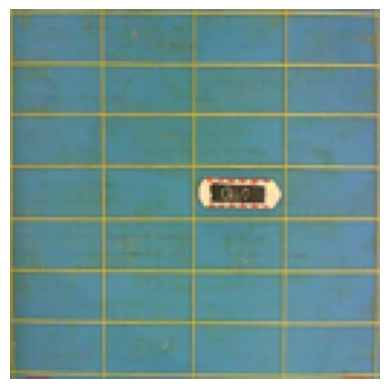

In [8]:
import matplotlib.pyplot as plt

# Display the first image
plt.imshow(processed_images_train[5])
plt.axis('off')  # Hide the axis
plt.show()

In [14]:
empty_labels_train

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - AUC: 0.5651 - accuracy: 0.8030 - loss: 0.5028 - val_AUC: 0.9478 - val_accuracy: 0.8073 - val_loss: 0.3322
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - AUC: 0.9826 - accuracy: 0.8768 - loss: 0.2026 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.1228
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.1007 - val_AUC: 1.0000 - val_accuracy: 0.9969 - val_loss: 0.0216
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - AUC: 1.0000 - accuracy: 0.9968 - loss: 0.0053 - val_AUC: 0.9921 - val_accuracy: 0.9969 - val_loss: 0.0268
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 6.2224e-04 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.6057e-04
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - AUC: 1.0000 - accuracy: 0.9975 - loss: 0.0038 - val_AUC: 0.9206 - val_accuracy: 0.9480 - val_loss: 0.6488
Epoch 7/10
41/41 ━━━━━━━━━━━━━━

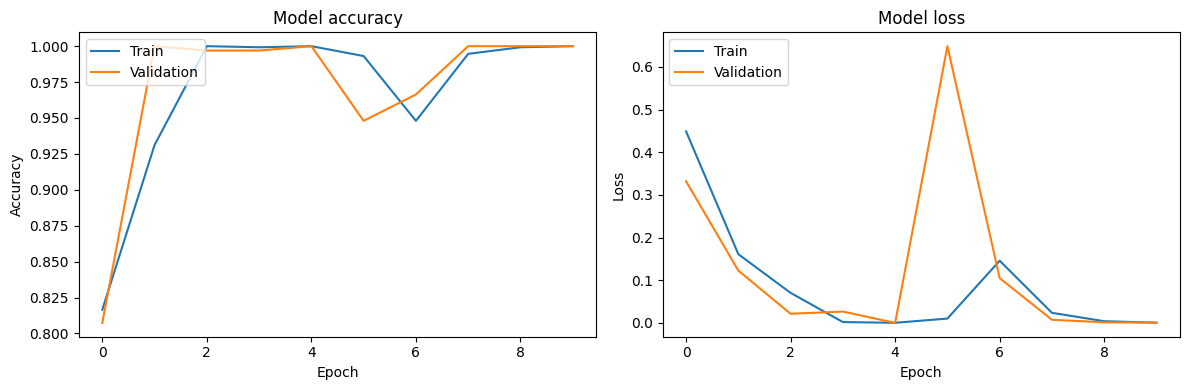

In [15]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import matplotlib.pyplot as plt

class ShipClassifier(models.Model):
    def __init__(self):
        super(ShipClassifier, self).__init__()
        
        # Define sequential model for easier forward pass
        self.model = keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
        
    def call(self, x):
        return self.model(x)

# Create and compile model
model_ship_present = ShipClassifier()
model_ship_present.build((None, 128, 128, 3))  # Build model with input shape
model_ship_present.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy', 'AUC'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(processed_images_train, empty_labels_train, test_size=0.2, random_state=42)

# Train the model
history = model_ship_present.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
# Get predictions for all validation images
predictions_ship_present = model_ship_present.predict(X_val)

# Convert predictions to binary values (0 or 1) using threshold of 0.5
binary_predictions_ship_present = (predictions_ship_present > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(binary_predictions_ship_present.flatten() == np.array(y_val))
print(f'Validation Accuracy: {accuracy:.4f}')

# Print first few predictions and their actual values
print("\nFirst 10 predictions:")
for i in range(10):
    print(f"Predicted: {binary_predictions_ship_present[i][0]}, Actual: {y_val[i]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Validation Accuracy: 0.6889

First 10 predictions:
Predicted: 0, Actual: [0]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]


In [19]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# First, let's create a copy of the labels and replace None with a string 'None'
shiptype_labels = [str(label) if label is not None else 'None' for label in shiptype_label_train]

# Create and fit the LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(shiptype_labels)

# Create and fit the OneHotEncoder
onehot_encoder = OneHotEncoder()
encoded_labels_reshaped = encoded_labels.reshape(-1, 1)
onehot_labels = onehot_encoder.fit_transform(encoded_labels_reshaped)

# Print the mapping and shape
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("One-hot encoded shape:", onehot_labels.shape)
print("Number of classes:", len(label_encoder.classes_))

# Now onehot_labels can be used for training the classifier

Label mapping: {np.str_('Cruiser-1'): np.int64(0), np.str_('Cruiser-2'): np.int64(1), np.str_('Cruiser-3'): np.int64(2), np.str_('Fishing-1'): np.int64(3), np.str_('Fishing-2'): np.int64(4), np.str_('Freighter'): np.int64(5), np.str_('None'): np.int64(6)}
One-hot encoded shape: (1635, 7)
Number of classes: 7


In [37]:
encoded_labels_reshaped[0]

array([6])

In [48]:
# Ship Type Classifier
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

class ShipClassifier(models.Model):
    def __init__(self):
        super(ShipClassifier, self).__init__()
        
        # Define sequential model for easier forward pass
        self.model = keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(7, activation='softmax')
        ])
        
    def call(self, x):
        return self.model(x)

# Create and compile model
model_ship_type = ShipClassifier()
model_ship_type.build((None, 128, 128, 3))
model_ship_type.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
X_train, X_val, y_train, y_val = train_test_split(processed_images_train, encoded_labels, test_size=0.2, random_state=42)

# Train the model
history = model_ship_type.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 1.9926 - sparse_categorical_accuracy: 0.1459 - val_loss: 1.9342 - val_sparse_categorical_accuracy: 0.1927
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 1.9417 - sparse_categorical_accuracy: 0.1875 - val_loss: 1.9313 - val_sparse_categorical_accuracy: 0.1927
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 1.9153 - sparse_categorical_accuracy: 0.2280 - val_loss: 1.7667 - val_sparse_categorical_accuracy: 0.3700
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 1.5457 - sparse_categorical_accuracy: 0.4162 - val_loss: 1.2102 - val_sparse_categorical_accuracy: 0.5107
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 0.8844 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.7582 - val_sparse_categorical_accuracy: 0.7095
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.5282 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.5362 - val_sparse_categorical_accuracy: 0.7737
Epoc

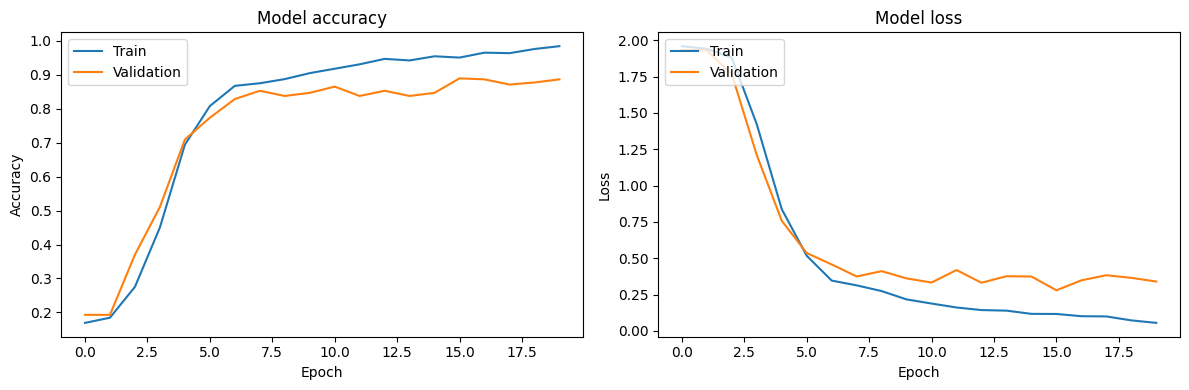

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [50]:
# Get predictions for all test images
predictions_ship_type = model_ship_type.predict(processed_images_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions_ship_type, axis=1)

# Convert numeric predictions back to original labels
predicted_ship_types = label_encoder.inverse_transform(predicted_classes)

# Print first few predictions and their actual labels
print("\nFirst 10 predictions:")
for i in range(10):
    print(f"Predicted: {predicted_ship_types[i]}, Actual: {shiptype_label_test[i]}")

# Calculate accuracy
accuracy = np.mean(predicted_ship_types == shiptype_label_test)
print(f'\nTest Accuracy: {accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

First 10 predictions:
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-1, Actual: Cruiser-1
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-2, Actual: Cruiser-2
Predicted: Fishing-1, Actual: Fishing-2
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: None, Actual: None
Predicted: Cruiser-1, Actual: Cruiser-1
Predicted: Fishing-2, Actual: Fishing-2

Test Accuracy: 0.6975
